<a href="https://colab.research.google.com/github/wenjunsun/Covid-19-analysis-with-uw-ubicomp/blob/master/week11/PSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook does PSM to see if the policy of shelter in place has effects on people's percentage of time spent staying at home, and percentage of full time and part time jobs.  

# 0. load some R packages

In [1]:
cd drive/My\ Drive/week11

/content/drive/My Drive/week11


In [2]:
# if we don't do this there will be annoying warnings
# for using some of the R in jupyter...
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings('ignore', category = FutureWarning)
warnings.filterwarnings('ignore', category = RRuntimeWarning)

In [3]:
# enable R to python in Colab
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [4]:
import numpy as np
import pandas as pd

# For (automatic) translation of Pandas objects to R
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [5]:
%%R
# install standard propensity matching library in R 
install.packages("MatchIt")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependency ‘Matching’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/Matching_4.9-7.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 298404 bytes (291 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write t

In [6]:
%%R
# load MatchIt package
library(MatchIt)

In [7]:
%%R
# install Coarsened Exact Matching package
install.packages('cem')
library(cem)

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘combinat’, ‘randomForest’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/combinat_0.0-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 9197 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[

# 1. Propensity score matching with new data without low device count + new covariates

In [8]:
ls

 2016_US_County_Level_Presidential_Results.csv
'2020 County Health Rankings Data - Additional Measure Data.csv'
'2020 County Health Rankings Data - Ranked Measure Data.csv'
 aggregated_data.csv
 county_data_with_reduced_covariates.csv
 days_since.csv
 plot_time_series.ipynb
 prepare_data_for_PSM.ipynb
 PSM.ipynb
 us_states_governors.csv


In [9]:
dataframe = pd.read_csv("county_data_with_reduced_covariates.csv")

In [10]:
# look at our data
dataframe.head()

,state,state_code,State Name,cnamelong,county_code,diff_in_perc_time_home,diff_in_perc_full_time,diff_in_perc_part_time,SIP?,Median Household Income,% Rural,Population_y,political_diff,% less than 18 years of age,% 65 and over,% Asian,% Black,% Hispanic,% Non-Hispanic White
0,1.0,AL,Alabama,Autauga County,1001.0,0.113066,-0.017918,-0.044274,1,59338.0,42.0,55601,-0.494789,23.7,15.6,1.2,19.3,3.0,74.3
1,1.0,AL,Alabama,Baldwin County,1003.0,0.101178,-0.012819,-0.031885,1,57588.0,42.3,218022,-0.577862,21.6,20.4,1.2,8.8,4.6,83.1
2,1.0,AL,Alabama,Barbour County,1005.0,0.068609,-0.011850,-0.021389,1,34382.0,67.8,24881,-0.056112,20.9,19.4,0.5,48.0,4.3,45.6
3,1.0,AL,Alabama,Bibb County,1007.0,0.086205,-0.022101,-0.027307,1,46064.0,68.4,22400,-0.555441,20.5,16.5,0.2,21.1,2.6,74.6
4,1.0,AL,Alabama,Blount County,1009.0,0.088145,-0.025352,-0.036392,1,50412.0,90.0,57840,-0.813820,23.2,18.2,0.3,1.5,9.6,86.9


In [11]:
print(f"this dataset has {dataframe.shape[0]} records.")

this dataset has 3140 records.


In [12]:
dataframe.dropna(inplace=True)

In [13]:
print(f"after dropping this dataset has {dataframe.shape[0]} records.")

after dropping this dataset has 3135 records.


So we only have one record with null values in it, which is good

In [14]:
# look at variables we have in R. (% sign is messed up)
%%R -i dataframe
head(dataframe)

  state state_code State.Name      cnamelong county_code diff_in_perc_time_home
0     1         AL    Alabama Autauga County        1001             0.11306633
1     1         AL    Alabama Baldwin County        1003             0.10117823
2     1         AL    Alabama Barbour County        1005             0.06860850
3     1         AL    Alabama    Bibb County        1007             0.08620452
4     1         AL    Alabama  Blount County        1009             0.08814533
5     1         AL    Alabama Bullock County        1011             0.04338218
  diff_in_perc_full_time diff_in_perc_part_time SIP. Median.Household.Income
0            -0.01791829            -0.04427444    1                   59338
1            -0.01281902            -0.03188528    1                   57588
2            -0.01185009            -0.02138910    1                   34382
3            -0.02210120            -0.02730729    1                   46064
4            -0.02535157            -0.03639227    1   

In [15]:
# -i means pass in some argument/data from python world to R world
%%R -i dataframe

# using MatchIt package to do PSM - guess it used logistic regression?

m.out <- matchit(SIP.~Median.Household.Income + X..Rural +
                 political_diff+
                 X..Asian + X..Black + 
                 X..Non.Hispanic.White +
                 X..Hispanic,
                 method = "cem", data = dataframe) # cem = coarse exact matching


Using 'treat'='1' as baseline group


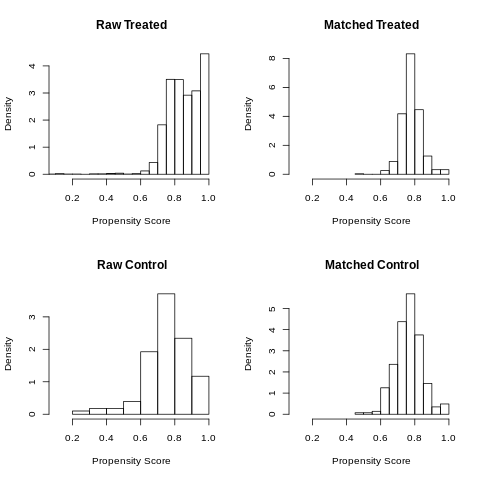

In [16]:
# to see how maching it soind by visualizing distributions
%%R
plot(m.out, type='hist')

[1] "To identify the units, use first mouse button; to stop, use second."
integer(0)


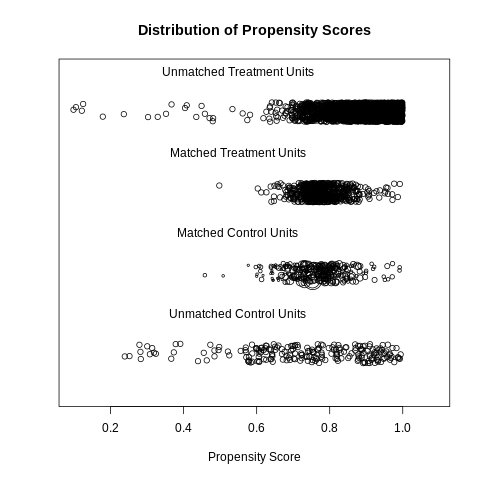

In [17]:
%%R
plot(m.out, type='jitter')

In [18]:
%%R
summary(m.out, standardize=T)


Call:
matchit(formula = SIP. ~ Median.Household.Income + X..Rural + 
    political_diff + X..Asian + X..Black + X..Non.Hispanic.White + 
    X..Hispanic, data = dataframe, method = "cem")

Summary of balance for all data:
                        Means Treated Means Control SD Control Std. Mean Diff.
distance                       0.8558        0.7528     0.1306          1.0197
Median.Household.Income    52858.2550    52532.2222 10354.0323          0.0225
X..Rural                      56.6499       68.4734    29.4844         -0.3752
political_diff                -0.2929       -0.4475     0.2328          0.4913
X..Asian                       1.6896        0.9341     1.2334          0.2387
X..Black                      10.0607        3.6260     8.7236          0.4307
X..Non.Hispanic.White         74.7858       82.7423    15.5670         -0.3857
X..Hispanic                   10.3455        6.1333     6.0350          0.2848
                        eCDF Med eCDF Mean eCDF Max
distance      

we can see from the histogram and jitter plot and summary statistics that this matching is pretty good! - Std. Mean Diff are all $\le$ 0.05, which is good

In [19]:
%%R
# extract matched data.
matched_data <- match.data(m.out)

In [20]:
# import dataframe from R to python.... since I am not familar with manipulating
# R objects 
matched_data = %R matched_data

In [21]:
matched_data.head()

,state,state_code,State.Name,cnamelong,county_code,diff_in_perc_time_home,diff_in_perc_full_time,diff_in_perc_part_time,SIP.,Median.Household.Income,X..Rural,Population_y,political_diff,X..less.than.18.years.of.age,X..65.and.over,X..Asian,X..Black,X..Hispanic,X..Non.Hispanic.White,distance,weights,subclass
14,1.0,AL,Alabama,Cleburne County,1029.0,0.081698,-0.015703,-0.025147,1,46495.0,100.0,14987,-0.773729,22.8,19.5,0.2,2.9,2.5,92.8,0.688206,1.000000,633
41,1.0,AL,Alabama,Limestone County,1083.0,0.118461,-0.017724,-0.047195,1,64863.0,57.6,96174,-0.494518,22.6,15.2,1.6,13.5,6.1,76.1,0.833394,1.000000,1624
60,1.0,AL,Alabama,Talladega County,1121.0,0.081974,-0.015768,-0.032364,1,41630.0,55.8,79828,-0.255524,21.2,18.0,0.7,32.6,2.4,62.5,0.950433,1.000000,432
108,4.0,AZ,Arizona,Yavapai County,4025.0,0.052146,-0.010039,-0.018367,1,48758.0,33.2,231993,-0.314260,16.2,31.6,1.2,0.7,14.7,80.4,0.875396,1.000000,817
112,5.0,AR,Arkansas,Baxter County,5005.0,0.049920,-0.004508,-0.015891,0,39686.0,65.8,41619,-0.536072,17.7,30.9,0.5,0.4,2.5,94.5,0.778454,1.205651,449


In [22]:
no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
 matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
* matched_data[matched_data['SIP.'] == 0]['diff_in_perc_time_home']).sum()

In [23]:
SIP_diff = matched_data[matched_data['SIP.'] == 1]['diff_in_perc_time_home'].mean()

In [24]:
# change in behavior that is brought by SIP policy
# this is for diff in percentage of time people spend at home
SIP_diff - no_SIP_diff

0.0031591851675872307

In [47]:
no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
 matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
* matched_data[matched_data['SIP.'] == 0]['diff_in_perc_full_time']).sum()

In [48]:
SIP_diff = matched_data[matched_data['SIP.'] == 1]['diff_in_perc_full_time'].mean()

In [50]:
# this is diff of percentage of full time work devices
SIP_diff - no_SIP_diff

0.0012584026222512527

In [51]:
no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
 matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
* matched_data[matched_data['SIP.'] == 0]['diff_in_perc_part_time']).sum()

In [52]:
SIP_diff = matched_data[matched_data['SIP.'] == 1]['diff_in_perc_part_time'].mean()

In [53]:
# this is diff of percentage of part time work devices.
SIP_diff - no_SIP_diff

-0.0019964861832602876

# Conclusion

In [45]:
def analyzeVariable(variable_name):

  no_SIP_diff = ((matched_data[matched_data['SIP.'] == 0]['weights'] / \
  matched_data[matched_data['SIP.'] == 0]['weights'].sum()) \
  * matched_data[matched_data['SIP.'] == 0][variable_name]).sum()

  SIP_diff = matched_data[matched_data['SIP.'] == 1][variable_name].mean()

  print(f'for variable {variable_name}, counties without SIP have increased {no_SIP_diff * 100}% during COVID' + 
        f' while counties with SIP increased {SIP_diff * 100}%, with a difference of {(SIP_diff - no_SIP_diff)*100}%')
  policy_importance = (SIP_diff - no_SIP_diff) / SIP_diff
  print(f'the shelter in place policy contributes {policy_importance * 100}% to change in {variable_name}')
  print()

In [46]:
for variable in ['diff_in_perc_time_home', 'diff_in_perc_full_time', 'diff_in_perc_part_time']:
  analyzeVariable(variable)

for variable diff_in_perc_time_home, counties without SIP have increased 6.255606613644726% during COVID while counties with SIP increased 6.571525130403449%, with a difference of 0.31591851675872307%
the shelter in place policy contributes 4.807385051258682% to change in diff_in_perc_time_home

for variable diff_in_perc_full_time, counties without SIP have increased -1.714099684195061% during COVID while counties with SIP increased -1.588259421969936%, with a difference of 0.1258402622251253%
the shelter in place policy contributes -7.92315540423769% to change in diff_in_perc_full_time

for variable diff_in_perc_part_time, counties without SIP have increased -2.573648511411028% during COVID while counties with SIP increased -2.773297129737057%, with a difference of -0.19964861832602876%
the shelter in place policy contributes 7.198962425816881% to change in diff_in_perc_part_time



As we can see, there are not much difference that is brought by shelter in place policy. It increase people's percentage of staying at home by 0.3%, increases percentage of full time devices by 0.12%, and it decreases percentage of part time by 0.2%. 